# Human Cortical Timescale: Dynamic Modulation of Timescale During Working Memory
In this notebook, we look at the modulation of neuronal timescale in the frontal cortex of humans during a working memory task.

---
So far, our data has shown that (spatial) variations in cortical timescale is related to anatomical gradients in the cortex, such as gene expression and grey matter myelination. In addition, timescale changes over aging, as one would expect if the underlying brain anatomy is changing via alteration and loss of specific cell types or synapses. As such, different cortical areas should have a clear division of roles: areas with short vs. long intrinsic timescales (i.e., sensory vs. association) should be "responsible" for short- vs. long- timescale information relevant for behavior, respectively. In other words, a cortical area should only take on computation if its timescale satisfies what's required by the task, and pass it onto another brain region with more appropriate timescales if not. Previous findings in animal studies have supported this, showing region-specific segregation of task information during decision-making ([Runyan et al., 2017][runyan2017]) and working memory ([Wasmuht et al., 2017][wasmuht2017]) tasks.

Under this view, however, the timescale of each cortical region is rigidly defined by its anatomy, which does not change. An alternative possibility is that region-specific timescales can also be dynamically modulated in real-time by requirements during behavior, i.e., a circuit will have an intrinsic timescale _range_ that is defined largely by its anatomy, and reflected in its resting-state dynamics. When recruited for a behavior, however, the circuit can move within its range of timescales as required.

Here, we test whether cortical timescales can be behaviorally-modulated. We analyze another publically available human ECoG dataset where 15 subjects are performing a visuospatial working memory task that requires a delayed response ([Johnson et al., 2018][johnson2018]). We aggregate over task conditions in the original study and simply ask whether neuronal timescale in the frontal cortices are different between resting (pre-stimulus) and memory maintenance (delay), both of which were absent of any external stimuli. We hypothesized that, since participants are required to hold onto information for task-response later, timescale of neuronal activity in frontal regions should be longer during delay period than pre-stimulus period, possibly reflecting an increase of recurrent activity.

---
ECoG data is taken from CRCNS datasets [fcx-2 and fcx-3][crcnsfcx]. The two datasets have 15 unique subjects with frontal coverage (OFC, PFC, etc.) performing the same task. See original[ publication][johnson2018] and data repository for detailed descriptions of the task and dataset. Briefly, each trial has one pre-stimulus epoch and two encoding epochs. We performed Hamming-windowed Fourier Transform on the last 900ms of data in each epoch to avoid stimulus-offset related ERPs, extracted timescale estimates from the PSD, and averaged the two delay periods. Timescale differences are taken as the logged ratio of delay:prestim periods. This was performed for each trial and channel separately, and timescale differences were then averaged across channels for a per-trial timescale difference. One-sample, two-tailed t-test was performed on timescale differences over all trials for each subject, for a per-subject t-value of difference. We also average over all trials to get per-subject timescale differences (`'tau_tval'` and `'tau_diff'` in the dataframe below). This was repeated for other fooof-fitted PSD parameters (offset and exponent), as well as theta (3-8Hz) and high-frequency activity (HFA, 70-100Hz) power, for model comparison. 

Code for computing single-trial features are in ../4_analysis_human_wm.ipynb. This notebook contains code for aggregating and performing statistics on the pooled data.

---
#### TL;DR: we hypothesized that neuronal timescale can also be modulated dynamically by behavior, and found that, indeed, ECoG timescales in human frontal regions are longer during the delay period of a working memory task than pre-stimulus baseline.

[runyan2017]: https://www.nature.com/articles/nature23020
[wasmuht2017]: https://www.nature.com/articles/s41467-018-05961-4
[johnson2018]: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2004274
[crcnsfcx]: https://crcns.org/data-sets/fcx

In [48]:
%load_ext autoreload
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr, spearmanr
import statsmodels.formula.api as smf

# custom
import sys
sys.path.append('../')
import echo_utils

# plotting stuff
import matplotlib.pyplot as plt
from seaborn import despine

# plot settings
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}

plt.rc('font', **font)
fig_path = '../figures/jwm/%s.pdf'
save_plot=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single-trial Fits of Timescale

### Collect FOOOF fits, and perform outlier detection after merging all (valid) trials across channels & subjects

In [2]:
# load metadata
df_patient_info = pd.read_csv('../data/df_johnson_patient_info.csv', index_col=0)
result_path = '../data/johnson/'

# load data features
feature_names = ['offset', 'exp', 'knee', 'tau', 'theta', 'hfa']
feature_list = []
for ff in feature_names:
    print(ff, end='| ')
    with open(result_path + "all_%s.txt"%ff, "rb") as fp: # unpickling
        feature_list.append(pickle.load(fp))

# collect all trials into df
col_names = ['patient', 'cond', 'trial', 'chan'] + feature_names
df_alltrials = pd.DataFrame(columns=col_names)

# s3 has really bad data (see PSDs), s15 & s17 are same as s5 & s8
patient_id = range(1,18) # patients go from s1-s17
patient_inds = [0,1,3,4,5,6,7,8,9,10,11,12,13,15]

# collect into a big dataframe, one row for each trial of every patient and electrode
for i_p in patient_inds:
    patient_mat = patient_id[i_p]*np.ones_like(feature_list[0][i_p])
    nchans, ntrials = feature_list[0][i_p][0].shape
    # make channel metadata matrices
    cond_mat = np.ones_like(feature_list[0][i_p])*np.array([0,1,2])[:,None,None]
    trial_mat = np.repeat(np.outer(np.ones((nchans,1)), np.arange(ntrials)[None,:])[None,:,:], 3, axis=0)
    chan_mat = np.repeat(np.outer(np.ones((ntrials,1)), np.arange(nchans)[None,:]).T[None,:,:], 3, axis=0)
    
    ft_agg = [patient_mat.flatten(), cond_mat.flatten(), trial_mat.flatten(), chan_mat.flatten()]
    # unpack feature and collect into df
    for ft in feature_list:
        ft_agg.append(ft[i_p].flatten())
    df_cur = pd.DataFrame(np.array(ft_agg).T, columns=col_names)
    df_alltrials = df_alltrials.append(df_cur, ignore_index=True)

# discard all trials with really bad slope fits (must be between 0 and 8) and tau fits (between 0 and 1)
df_alltrials.loc[((df_alltrials['exp']<0) | (df_alltrials['exp']>8)| (df_alltrials['tau']<=0) | (df_alltrials['tau']>1)), feature_names] = np.nan

offset| exp| knee| tau| theta| hfa| 

### Compute for all features

In [68]:
# outlier detection, doesn't really matter what you use beyond z = 3
z_outlier = 5
log_tau = False
global_outlier = False # do outlier detection per subject or pooled, also makes no real difference

df_operating = df_alltrials.copy()
grand_avg = []
valid_pat = np.unique(df_operating['patient'])

if global_outlier:
    # global outliers, discard based on tau outlier
    x = df_operating['tau']
    z = np.abs((x-np.nanmean(x))/np.nanstd(x))
    df_operating.loc[z>z_outlier, feature_names]=np.nan

# collect all patients
for i_p in valid_pat:
    # loop over patients
    df_p = df_operating[(df_operating['patient']==i_p)].copy()
    
    if not global_outlier:
        # within subject outliers
        x = df_p['tau']        
        z = np.abs((x-np.nanmean(x))/np.nanstd(x))
        df_p.loc[z>z_outlier, feature_names]=np.nan        
    
#     if log_tau:
#         df_p['tau'] = np.log10(df_p['tau'])
    
    # pre-stim epoch
    df_pre = df_p[df_p['cond']==0]
    
    # get avg values for delay periods during encoding epoch
    arr_enc = (df_p[df_p['cond']==1].values + df_p[df_p['cond']==2].values)/2    
    df_enc = pd.DataFrame(arr_enc, columns=col_names, index=df_pre.index) 

    # log timescale values because non-normal
    if log_tau:
        df_pre['tau'] = np.log10(df_pre['tau'])
        df_enc['tau'] = np.log10(df_enc['tau'])
    
    # compute feature diff and channel average across trials
    f_collect = []
    n_nans = 0
    for g, g_df in df_pre.groupby('trial'):
        f_pre = df_pre.loc[g_df.index][feature_names]
        f_enc = df_enc.loc[g_df.index][feature_names]

        # compute feature difference
        f_diff = f_enc - f_pre
        # average over channels
        f_collect.append(np.nanmean(f_diff,0))
        # count how many nans to estimate data quality
        n_nans += np.isnan(f_diff).sum()['tau']

    f_collect = np.array(f_collect)

    # t-test on diff of measures
    tval = ttest_1samp(f_collect, 0, nan_policy='omit')[0]
    data_qual = (1-n_nans/len(df_pre))*100
    
    # collect
    grand_avg.append(np.concatenate(([data_qual], np.nanmean(f_collect, 0), tval)))
    
grand_avg = np.array(grand_avg)

                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     7.577
Date:                Tue, 21 Jan 2020   Prob (F-statistic):            0.00854
Time:                        16:55:15   Log-Likelihood:                 23.886
No. Observations:                  14   AIC:                            -41.77
Df Residuals:                      11   BIC:                            -39.85
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6963      0.056     12.363      0.0

,tau_diff,tau_tval
s1,-0.002797,-1.457423
s2,-0.001525,-0.841141
s4,0.000316,0.206466
s5,0.000997,0.601476
s6,0.001293,0.900627
s7,0.000573,0.447339
s8,0.003935,0.471993
s9,-0.001548,-1.832224
s10,0.002215,1.831718
s11,0.000021,0.014068


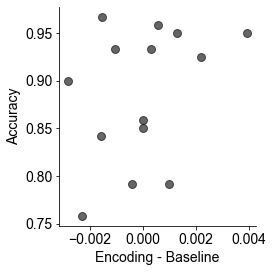

In [69]:
# run stats
df_result = pd.DataFrame(grand_avg, index=df_patient_info.index.values[patient_inds], 
                         columns=['data_qual'] + [fn+'_diff' for fn in feature_names] + [fn+'_tval' for fn in feature_names])

# pool behavioral data (average of RT and accuracy)
df_patient = pd.concat((df_patient_info.loc[df_result.index], df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)

# GLM on accuracy
# mod = smf.ols(formula='acc ~ age + tau_diff + offset_diff + exp_diff + theta_diff + hfa_diff', data=df_patient)
mod = smf.ols(formula='acc ~ age + tau_diff', data=df_patient)
res = mod.fit()
print(res.summary())

# plot 
x = df_patient['tau_diff']
y = df_patient['acc']
plt.figure(figsize=(4,4))
plt.plot(x,y, 'ok', alpha=0.6, ms=8)
plt.xlabel('Encoding - Baseline');plt.ylabel('Accuracy');
plt.tight_layout(); despine()
#if save_plot: plt.savefig(fig_path%'corr_tdiff_acc', bbox_inches='tight')

print('-------------')
print('Pearson:', pearsonr(x,y))
print('Spearman: ', spearmanr(x,y,nan_policy='omit'))

print('------------')
print([fn+'_tval' for fn in feature_names])
print(ttest_1samp(df_patient[[fn+'_tval' for fn in feature_names]], 0)[1])
#print('t-test on t-values of diffs: ',ttest_1samp(df_patient['tau_tval'], 0, nan_policy='omit'))
df_patient[['tau_diff', 'tau_tval']]

In [41]:
(~np.isnan(df_diff['tau'])).sum()

10579

0.00013064182012547073 0.43494284798632626
Ttest_1sampResult(statistic=0.29375643769901055, pvalue=0.7689472812292324)
------
0.04795370500198295 0.436147083845354
Ttest_1sampResult(statistic=7.598063141390079, pvalue=3.2601681356691096e-14)
------
-0.005321405531045353 0.4863262471958124
Ttest_1sampResult(statistic=-1.501183759276652, pvalue=0.13332490433541094)
------


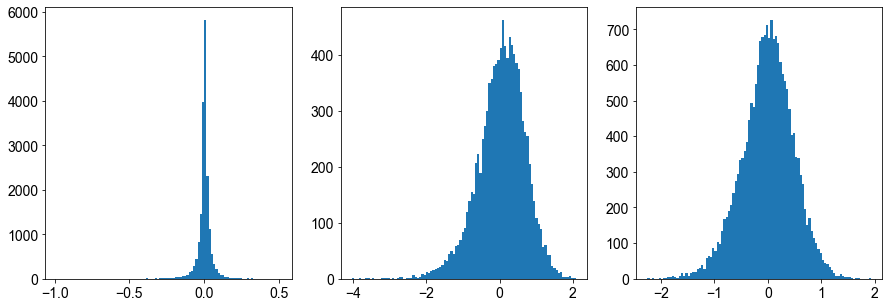

In [49]:
plt.figure(figsize=(15,5))

# door #1
plt.subplot(1,3,1)
df_pre = df_operating[df_operating['cond']==0]
df_enc = (df_operating[df_operating['cond']==1]+df_operating[df_operating['cond']==2].values)/2
df_diff = df_enc 
df_diff[feature_names] -= df_pre[feature_names].values
plt.hist(df_diff['tau'], 100);
print((df_diff['tau']).mean(), (df_diff['tau']<=0).sum()/(~np.isnan(df_diff['tau'])).sum())
print(ttest_1samp((df_diff['tau']), 0, nan_policy='omit'))
print('------')

# door #2
plt.subplot(1,3,2)
df_diff = np.log10(df_enc)
df_diff[feature_names] -= np.log10(df_pre[feature_names].values)
plt.hist(df_diff['tau'], 100);
print((df_diff['tau']).mean(), (df_diff['tau']<=0).sum()/(~np.isnan(df_diff['tau'])).sum())
print(ttest_1samp((df_diff['tau']), 0, nan_policy='omit'))
print('------')

# door #3
plt.subplot(1,3,3)
df_pre = np.log10(df_operating[df_operating['cond']==0])
df_enc = (np.log10(df_operating[df_operating['cond']==1])+np.log10(df_operating[df_operating['cond']==2].values))/2
df_diff = df_enc 
df_diff[feature_names] -= df_pre[feature_names].values
plt.hist(df_diff['tau'], 100);
print((df_diff['tau']).mean(), (df_diff['tau']<=0).sum()/(~np.isnan(df_diff['tau'])).sum())
print(ttest_1samp((df_diff['tau']), 0, nan_policy='omit'))
print('------')



Text(0, 0.5, 'log-after')

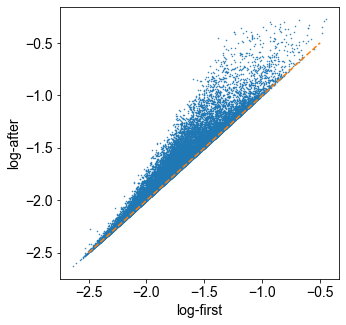

In [60]:
plt.figure(figsize=(5,5))
log_first = (np.log10(df_operating[df_operating['cond']==1])+np.log10(df_operating[df_operating['cond']==2].values))/2
log_after = np.log10((df_operating[df_operating['cond']==1]+df_operating[df_operating['cond']==2].values)/2)
plt.plot(log_first['tau'],log_after['tau'], '.', ms=1)
plt.plot([-2.5,-0.5],[-2.5,-0.5], '--')
plt.xlabel('log-first')
plt.ylabel('log-after')

### wtf is this true in general?

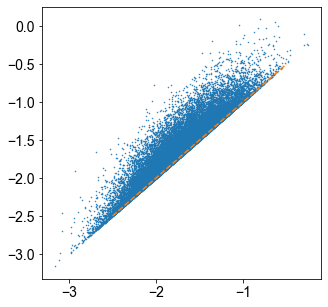

In [116]:
plt.figure(figsize=(5,5))
a = np.random.lognormal(-4, 1.2, 30000)
b = np.random.lognormal(-4, 1.2, 30000)
plt.plot((np.log10(a)+np.log10(b))/2, np.log10((a+b)/2), '.', ms=1)
plt.plot([-2.5,-0.5],[-2.5,-0.5], '--')

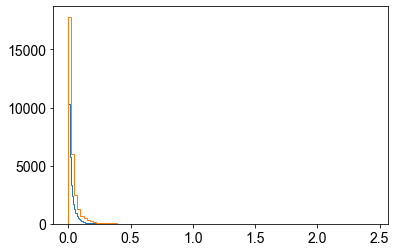

In [117]:
plt.hist(df_operating[df_operating['cond']==1]['tau'],100, histtype='step');
plt.hist(a,100, histtype='step');
#df_operating[df_operating['cond']==1]['tau'].mean()

In [10]:
#for a,b in df_diff.groupby(['patient', 'trial']):
    #print(a)

/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


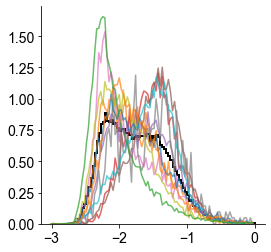

In [11]:
log_feat = True
feat = 'tau'
#bins = np.arange(np.floor(df_alltrials[feat].min()), np.ceil(df_alltrials[feat].max()), 0.02)
if log_feat:
    bins = np.linspace(np.floor(np.log10(df_alltrials[feat].min())), np.ceil(np.log10(df_alltrials[feat].max())), 100)    
else:
    bins = np.linspace(np.floor(df_alltrials[feat].min()), np.ceil(df_alltrials[feat].max()), 100)
    
plt.figure(figsize=(4,4))
for i_p in patient_inds:
    if log_feat:
        counts = np.histogram(np.log10(df_alltrials[df_alltrials['patient']==i_p][feat]), bins, density=True)[0]
    else:
        counts = np.histogram(df_alltrials[df_alltrials['patient']==i_p][feat], bins, density=True)[0]
        
    plt.plot(bins[:-1],counts, alpha=0.7)

if log_feat:
    plt.hist(np.log10(df_alltrials[feat]), bins, histtype='step', ec='k',lw=2, density=True);
else:
    plt.hist(df_alltrials[feat], bins, histtype='step', ec='k',lw=2, density=True);

despine();